In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import torch

In [2]:
ice_vel = xr.open_dataset('/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc')

In [3]:
ice_vel

<xarray.Dataset>
Dimensions:       (x: 12445, y: 12445)
Coordinates:
  * x             (x) float64 -2.8e+06 -2.8e+06 -2.799e+06 ... 2.799e+06 2.8e+06
  * y             (y) float64 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
    lat           (y, x) float64 ...
    lon           (y, x) float64 ...
Data variables:
    coord_system  |S1 ...
    VX            (y, x) float32 ...
    VY            (y, x) float32 ...
    STDX          (y, x) float32 ...
    STDY          (y, x) float32 ...
    ERRX          (y, x) float32 ...
    ERRY          (y, x) float32 ...
    CNT           (y, x) int32 ...
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_nsidc.CF16.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    spatial_resolution:        450m
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    license:                   No restrictions on access or use

# Define boundries of Byrd region

Subset area. Data set will be larger because of the 450 m gridding. We will interpolate at the laregt grid in a separate step.

Unit: meter/year

In [4]:
y_min = - 800000
y_max = - 1000000
x_min = 350000
x_max = (549500 + 500)

ice_vel_region = ice_vel.sel(y = slice(y_min, y_max), # reverse order
                             x = slice(x_min, x_max))


### Amery 

In [6]:
ice_vel_region.ERRX.values
ice_vel_region.ERRY.values

array([[3.7514162 , 3.8121083 , 3.763859  , ..., 0.41607115, 0.5923092 ,
        0.9066821 ],
       [3.7029455 , 3.735822  , 3.6990712 , ..., 0.37719068, 0.54763293,
        0.83043444],
       [3.6160512 , 3.5772088 , 3.4980054 , ..., 0.34351465, 0.45828828,
        0.6827127 ],
       ...,
       [1.88109   , 1.8652793 , 1.8532735 , ..., 1.6689659 , 1.6346679 ,
        1.6166245 ],
       [1.8805745 , 1.8690579 , 1.8570318 , ..., 1.6351614 , 1.603187  ,
        1.588828  ],
       [1.8801625 , 1.8719411 , 1.8642225 , ..., 1.6048459 , 1.5773202 ,
        1.569167  ]], dtype=float32)

## Visualise VX

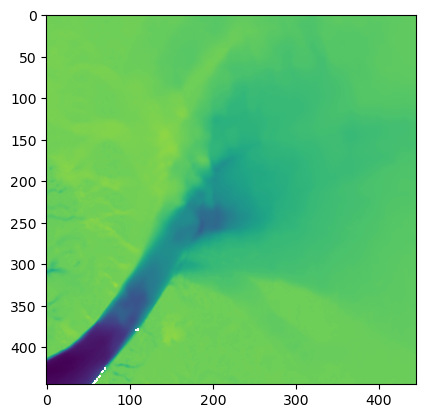

In [7]:
plt.imshow(ice_vel_region.VX.values, cmap = 'viridis')

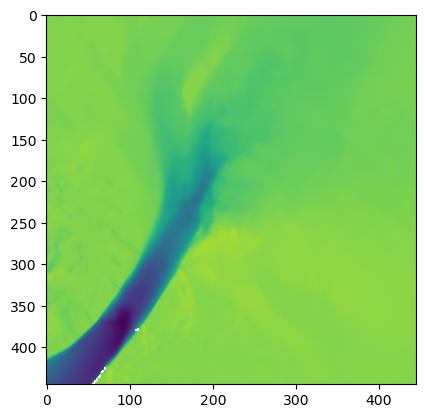

In [8]:
plt.imshow(ice_vel_region.VY.values, cmap = 'viridis')

## Visualise error

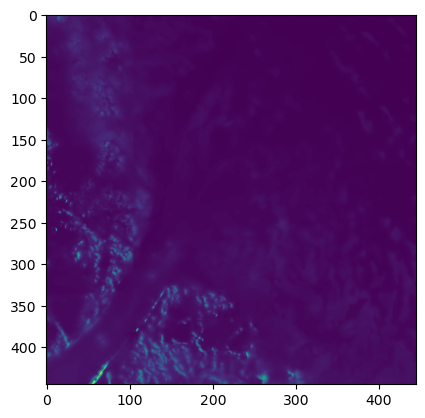

In [9]:
plt.imshow(ice_vel_region.ERRX.values, cmap = 'viridis')

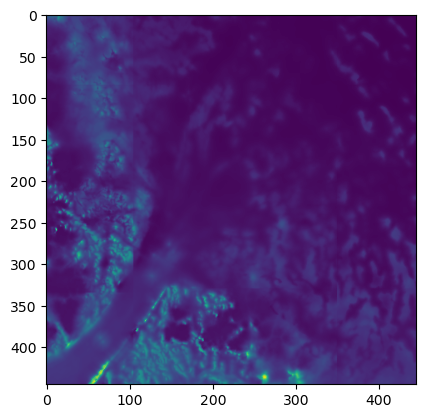

In [10]:
plt.imshow(ice_vel_region.ERRY.values, cmap = 'viridis')

## Target grid

In [11]:
target_grid = pd.read_csv("data/BedMachine_500mgrid_Byrd.csv")

In [12]:
target_grid

,x,y
0,350000,-800500
1,350500,-801000
2,351000,-801500
3,351500,-802000
4,352000,-802500
...,...,...
395,547500,-998000
396,548000,-998500
397,548500,-999000
398,549000,-999500


In [13]:
ice_vel_region.VX

<xarray.DataArray 'VX' (y: 445, x: 445)>
array([[ 1.726786e-01,  1.292136e-01,  7.641120e-01, ..., -2.051340e+01,
        -1.991157e+01, -1.990642e+01],
       [ 4.343407e-01,  3.609984e-01,  7.106878e-01, ..., -2.077227e+01,
        -2.014772e+01, -2.023184e+01],
       [ 1.172519e+00,  5.541978e-01,  2.022134e-01, ..., -2.087716e+01,
        -2.027881e+01, -2.037751e+01],
       ...,
       [-6.015182e+02, -6.006003e+02, -5.993353e+02, ..., -9.891382e+00,
        -8.677490e+00, -7.291644e+00],
       [-5.989401e+02, -5.984440e+02, -5.974952e+02, ..., -8.894300e+00,
        -8.028456e+00, -7.401615e+00],
       [-5.966781e+02, -5.971200e+02, -5.969083e+02, ..., -8.271576e+00,
        -7.614607e+00, -7.329248e+00]], dtype=float32)
Coordinates:
  * x        (x) float64 3.5e+05 3.504e+05 3.509e+05 ... 5.494e+05 5.498e+05
  * y        (y) float64 -8e+05 -8.004e+05 -8.009e+05 ... -9.994e+05 -9.998e+05
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
Attributes:
    long_name:      Ice velocity in x direction
    standard_name:  land_ice_x_velocity
    units:          meter/year
    grid_mapping:   coord_system

In [14]:
np.isnan(ice_vel_region.VX.values).sum()
np.isnan(ice_vel_region.VY.values).sum() # 20 nan each

20

# Because the grid is smaller we use nearest neighboor interpolation

This reduces the number of nan's.

In [15]:
# Interpolate the whole data set
ice_vel_interpolated = ice_vel.interp(y = (target_grid["y"]), x = (target_grid["x"]), method = "nearest")
ice_vel_interpolated

<xarray.Dataset>
Dimensions:       (y: 400, x: 400)
Coordinates:
    lat           (y, x) float64 -81.97 -81.97 -81.97 ... -79.53 -79.53 -79.53
    lon           (y, x) float64 156.4 156.4 156.3 156.3 ... 151.3 151.2 151.2
  * y             (y) int64 -800500 -801000 -801500 ... -999000 -999500 -1000000
  * x             (x) int64 350000 350500 351000 351500 ... 548500 549000 549500
Data variables:
    coord_system  |S1 b''
    VX            (y, x) float32 0.4343 0.361 0.7107 ... -8.369 -8.272 -7.615
    VY            (y, x) float32 -1.06 -0.8402 -0.5972 ... 3.102 3.247 3.813
    STDX          (y, x) float32 8.318 7.586 6.888 7.102 ... 4.38 4.467 4.424
    STDY          (y, x) float32 6.726 6.936 7.028 7.194 ... 4.456 4.429 4.168
    ERRX          (y, x) float32 3.095 3.152 3.135 3.194 ... 1.194 1.184 1.17
    ERRY          (y, x) float32 3.703 3.736 3.699 3.733 ... 1.634 1.605 1.577
    CNT           (y, x) float64 423.0 362.0 350.0 378.0 ... 550.0 565.0 588.0
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_nsidc.CF16.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    spatial_resolution:        450m
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    license:                   No restrictions on access or use

In [16]:
np.isnan(ice_vel_interpolated.VX.values).sum() # interpolation increases number of missing values 

17

The ice velocity is negative because ice flows in -x direction and in -y direction (minus y direction.)

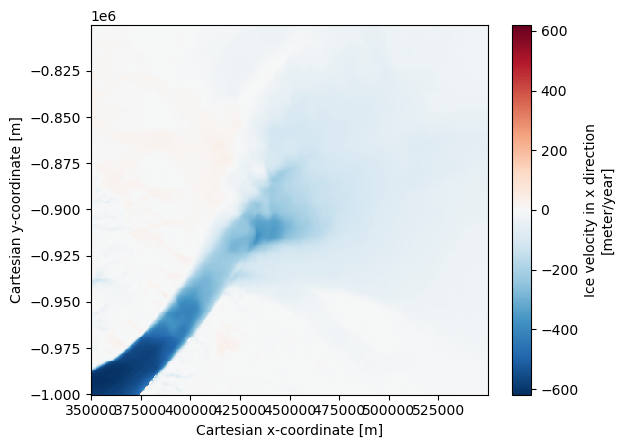

In [17]:
ice_vel_interpolated.VX.plot()

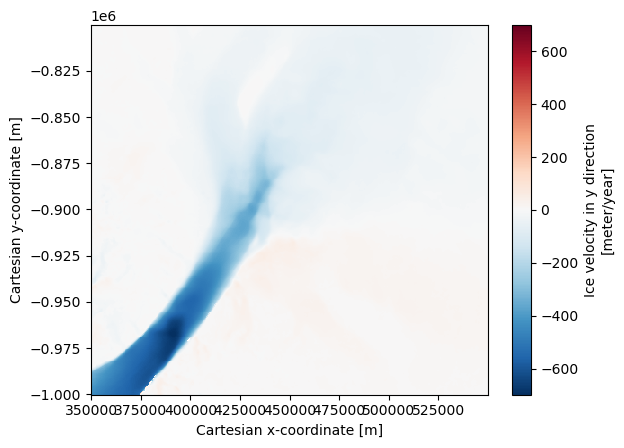

In [18]:
ice_vel_interpolated.VY.plot()

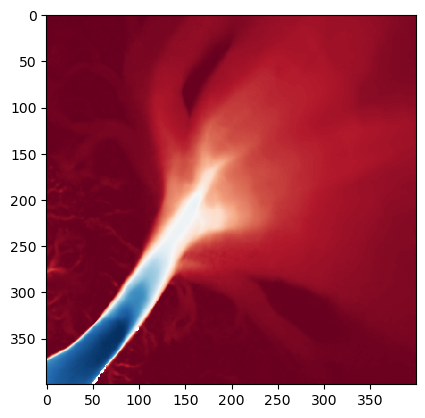

In [19]:
plt.imshow(np.sqrt(ice_vel_interpolated.VX.values**2 + ice_vel_interpolated.VY.values**2), cmap = "RdBu")

In [23]:
xx, yy = np.meshgrid(ice_vel_interpolated.x.values, ice_vel_interpolated.y.values)

# Change this to contain coordinate values

In [26]:
data = np.concatenate((ice_vel_interpolated.VX.values.reshape(1, 400, 400), ice_vel_interpolated.VY.values.reshape(1, 400, 400), xx.reshape(1, 400, 400), yy.reshape(1, 400, 400)))

torch.save(torch.tensor(data), "data/ice_vel_myr_VX_VY_x_y.pt")
# previously the cordinates were not included
# torch.save(torch.tensor(data), "data/ice_vel_VX_VY_myr.pt")

# Also create csv pd.DataFrame

In [28]:
print(data.shape)

# create long format
velocity_long = data.reshape(4, -1)

print(velocity_long.shape)

velocity_df = pd.DataFrame(velocity_long.T, columns = ['vx', 'vy', 'x', 'y'])
velocity_df

(4, 400, 400)
(4, 160000)


,vx,vy,x,y
0,0.434341,-1.059710,350000.0,-800500.0
1,0.360998,-0.840221,350500.0,-800500.0
2,0.710688,-0.597217,351000.0,-800500.0
3,-0.105596,-0.570826,351500.0,-800500.0
4,-1.258299,-0.594211,352000.0,-800500.0
...,...,...,...,...
159995,-5.763004,4.551172,547500.0,-1000000.0
159996,-7.035709,3.983489,548000.0,-1000000.0
159997,-8.368957,3.101594,548500.0,-1000000.0
159998,-8.271576,3.247080,549000.0,-1000000.0


In [29]:
velocity_df.to_csv("data/ice_vel_myr_VX_VY_x_y_flat.csv")